# Survival and Treatment Patterns in Chinese Cancer Patients (2010 – 2023)                           

## Alessandro Loddo

## Introduction

Cancer remains the leading cause of death in China, accounting for roughly **30 %** of all mortality in recent years. Understanding which demographic and clinical factors most strongly influence survival can guide resource allocation, public-health messaging, and everyday treatment choices.

For this project I worked with a **synthetic dataset of 10 000 anonymised cancer patients** diagnosed between **2010 – 2023** across **13 Chinese provinces**. Each row represents a unique patient and includes 20 attributes spanning:

- **Demographics** – age, gender, ethnicity, home province  
- **Clinical features** – tumour type (six major cancers), stage, size, metastasis status, key genetic mutations  
- **Lifestyle factors** – smoking and alcohol use  
- **Therapy details** – first-line treatment (surgery, chemotherapy, radiotherapy, targeted, immunotherapy) and follow-up length  
- **Outcome** – alive vs.\ deceased at last contact  

My analysis pursued three main questions:

1. **Which demographic and regional factors correlate with better (or worse) survival?**  
2. **Are particular cancer types or lifestyle habits linked to noticeably different survival odds?**  
3. **How do first-line treatment choices compare in real-world survival, and do patterns vary by province?**

The workflow combined data-cleaning in **pandas**, exploratory visualisation with **matplotlib / seaborn**, and an **interactive Folium map** to spotlight geographical hot-spots. All code is contained in the accompanying Jupyter notebook and the helper script `china_cancer_patients_map_visualizer_data.py`.

A **helper plugin**, implemented as a git submodule, was developed and aids the analysis of the previously described dataset. 

*Dataset size:* 10000 patient records • 20 variables  
*Period covered:* 2010 – Dec 2023 • 13 provinces/municipalities  
*Key takeaway:*

In [7]:
#Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns

import folium
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt

#Personal Helper Functions
import importlib
from data_analysis_helper_plugin import display_matplotlib_helperfunctions as hf_plt
from data_analysis_helper_plugin import display_seaborn_helperfunctions as hf_sns
import china_cancer_patients_map_visualizer_data as map_data
importlib.reload(hf_plt)
importlib.reload(hf_sns)

pd.set_option('display.max_columns', 200)
#For future CancerStage Roman Numerical Categorical to Integer, 
pd.set_option('future.no_silent_downcasting', True)

### Library Imports
All the necessary libraries, as well as the personally developed plugin are imported here.

In [8]:
#Import and read dataset 
data = pd.read_csv("china_cancer_patients_synthetic.csv")

Dataset is read and loaded here

# Dataset overview for data understanding

### Dataset Summary

> **Dataset size, row by column: 10000x20**
>
> Each row indicates unique patient, each column contains different attributes related to each patient:
> 
> **'PatientID', 'Gender', 'Age', 'Province', 'Ethnicity', 'TumorType',
>'CancerStage', 'DiagnosisDate', 'TumorSize', 'Metastasis',
>'TreatmentType', 'SurgeryDate', 'ChemotherapySessions',
>'RadiationSessions', 'SurvivalStatus', 'FollowUpMonths',
>'SmokingStatus', 'AlcoholUse', 'GeneticMutation', 'Comorbidities'**
>
> Dataset contains categorical data and missing data to be converted and cleaned, **no patient IDs duplicates are present**.
>
> **Missing data will be replaced with "Unknown"**, due to considerable size of missing data, dropping such a huge amount of patients' information would be crucial and negatively impactful. 
> 
> **Comorbidities and genetic mutation data with 5–10% missing values**
>
> Survival outcome and follow-up durations are up to 60 months.


In [9]:
data.shape

(10000, 20)

First step is to read size of dataset to get a first grasp on the amount of data that is being worked on.

In [10]:
(data.describe(include="all"))

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
count,10000,10000,10000.000000,10000,10000,10000,10000,10000,10000.000000,10000,10000,4327,10000.0000,10000.000000,10000,10000.000000,10000,4079,2800,6285
unique,10000,3,NaN,13,6,6,4,4383,NaN,2,5,2915,NaN,NaN,2,NaN,3,2,3,9
top,CHN-00001,Female,NaN,Guangdong,Han,Lung,II,2016-11-08,NaN,No,Chemotherapy,2012-09-23,NaN,NaN,Alive,NaN,Never,Occasional,EGFR,Hypertension
freq,1,3371,NaN,1841,9110,2561,2971,8,NaN,7301,2072,5,NaN,NaN,7790,NaN,5011,3127,1389,1514
mean,NaN,NaN,51.600200,NaN,NaN,NaN,NaN,NaN,6.339040,NaN,NaN,NaN,3.9990,3.046400,NaN,30.432800,NaN,NaN,NaN,NaN
std,NaN,NaN,19.705608,NaN,NaN,NaN,NaN,NaN,2.234999,NaN,NaN,NaN,6.2036,7.301505,NaN,17.162545,NaN,NaN,NaN,NaN
min,NaN,NaN,18.000000,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,0.0000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,NaN,4.800000,NaN,NaN,NaN,0.0000,0.000000,NaN,16.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,51.000000,NaN,NaN,NaN,NaN,NaN,6.400000,NaN,NaN,NaN,0.0000,0.000000,NaN,31.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,69.000000,NaN,NaN,NaN,NaN,NaN,7.900000,NaN,NaN,NaN,8.0000,0.000000,NaN,45.000000,NaN,NaN,NaN,NaN


 data.describe allows for a general brief understanding on which columns contain categorical and which columns contain numerical data, as well as grasping some general statistics on the numerical data.

In [11]:
data.head()

,PatientID,Gender,Age,Province,Ethnicity,TumorType,CancerStage,DiagnosisDate,TumorSize,Metastasis,TreatmentType,SurgeryDate,ChemotherapySessions,RadiationSessions,SurvivalStatus,FollowUpMonths,SmokingStatus,AlcoholUse,GeneticMutation,Comorbidities
0,CHN-00001,Male,32,Hunan,Han,Lung,I,2010-07-24,8.2,No,Radiation,2010-08-24,0,23,Alive,44,Current,NaN,NaN,NaN
1,CHN-00002,Male,66,Sichuan,Han,Lung,IV,2015-01-03,9.5,Yes,Chemotherapy,2015-03-24,11,0,Deceased,57,Never,Occasional,EGFR,"Hepatitis B, Hypertension"
2,CHN-00003,Other,26,Guangdong,Han,Lung,III,2022-03-26,9.3,Yes,Surgery,2022-07-14,0,0,Alive,40,Former,NaN,NaN,NaN
3,CHN-00004,Other,35,Anhui,Uyghur,Breast,III,2019-06-19,7.7,No,Surgery,2019-08-27,0,0,Deceased,45,Never,Occasional,KRAS,NaN
4,CHN-00005,Male,32,Guangdong,Han,Stomach,II,2012-02-07,7.3,No,Chemotherapy,NaN,4,0,Alive,42,Never,NaN,NaN,NaN


Now that general understandingof the dataset is obtained after data.describe, the first five columns will be checked using data.head() to see:
- Which format the data is in
- A general layout of the information within the dataset
- Understanding which features/columns need to be renamed or dropped, if necessary.
- Here for example, Roman numerals within CancerStage will need to be converted to numeric.
- Missing date in the 4th row hints to further missing values within surgery dates.

In [12]:
data.dtypes

PatientID                object
Gender                   object
Age                       int64
Province                 object
Ethnicity                object
TumorType                object
CancerStage              object
DiagnosisDate            object
TumorSize               float64
Metastasis               object
TreatmentType            object
SurgeryDate              object
ChemotherapySessions      int64
RadiationSessions         int64
SurvivalStatus           object
FollowUpMonths            int64
SmokingStatus            object
AlcoholUse               object
GeneticMutation          object
Comorbidities            object
dtype: object

- data.dtypes allows for checking which columns contain values that need to be converted, CancerStage can be converted to integer, SurgeryDate and DiagnosisDate can also be converted to dates

In [13]:
#Conversion of CancerStage from Roman Numeral to Int
data['CancerStage'] = data['CancerStage'].replace({'I': 1, 'II': 2, 'III': 3, 'IV': 4}).astype('Int64')
#data['CancerStage'].replace({'I': 1, 'II': 2, 'III': 3, 'IV': 4}, inplace = True)

- Conversion of CancerStage from roman categorical to numerical.

In [14]:
#Check for null values
data.isna().sum()

PatientID                  0
Gender                     0
Age                        0
Province                   0
Ethnicity                  0
TumorType                  0
CancerStage                0
DiagnosisDate              0
TumorSize                  0
Metastasis                 0
TreatmentType              0
SurgeryDate             5673
ChemotherapySessions       0
RadiationSessions          0
SurvivalStatus             0
FollowUpMonths             0
SmokingStatus              0
AlcoholUse              5921
GeneticMutation         7200
Comorbidities           3715
dtype: int64

To work with the data, **the dataset should not contain null values**, here an idea of how many null values is obtained.

The **Dataset contains a high number of null values within SurgeryDate, AlcoholUse, GeneticMutation and Comorbidities.**
This could indicate, for example, that the null values in **AlcoholUse mean "Negative Usage"**, **care needs to be taken when replacing/assigning null values.**

The **AlcoholUsage null values will be replaced with "None", as the dataset contains "Null, Occasional, Heavy".**

**For the remaining Columns, the value "Unknown" will be assigned.**

In [26]:
#Convert DiagnosisDate and SurgeryDate to datetime rather than object.
for col in ['SurgeryDate', 'DiagnosisDate']:
    data[col] = pd.to_datetime(data[col], errors='coerce')

#Replace null values with "Unknown" within DiagnosisDate and SurgeryDate, dropping rows or columns would lose vital information, especially considering how many null values are present
#This converts SurgeryDates to object types, whereas DiagnosisDate is a datetime64.
#This is because we are filling the null values of the SurgeryDates, whereas DiagnosisDate does not present any null value.
#One option to fix this is keep SurgeryDates null values to NaT, but for display and ease purposes, as well as the fact that this analysis does not specifically focus on SurgeryDates, this will not be the solution chosen.
data = data.fillna("Unknown")

In [23]:
#Make sure no data is null anymore, but filled with "Unknown" for future analysis
data.isna().sum()

PatientID               0
Gender                  0
Age                     0
Province                0
Ethnicity               0
TumorType               0
CancerStage             0
DiagnosisDate           0
TumorSize               0
Metastasis              0
TreatmentType           0
SurgeryDate             0
ChemotherapySessions    0
RadiationSessions       0
SurvivalStatus          0
FollowUpMonths          0
SmokingStatus           0
AlcoholUse              0
GeneticMutation         0
Comorbidities           0
dtype: int64

Verify how many values are still null after different conversions.

In [24]:
#Check data types match what is expected
data.dtypes

PatientID                       object
Gender                          object
Age                              int64
Province                        object
Ethnicity                       object
TumorType                       object
CancerStage                      Int64
DiagnosisDate           datetime64[ns]
TumorSize                      float64
Metastasis                      object
TreatmentType                   object
SurgeryDate                     object
ChemotherapySessions             int64
RadiationSessions                int64
SurvivalStatus                  object
FollowUpMonths                   int64
SmokingStatus                   object
AlcoholUse                      object
GeneticMutation                 object
Comorbidities                   object
dtype: object

# First iteration of Exploratory Analysis 

>Now that the dataset is cleaned and the missing information has been replaced with "Unknown" values, the dataset is clean and can be explored in preparation for answering the original questions, as well as investigating possible improvements regarding cancer treatment and cancer treatment promptness.
>
>Before diving into the in-depth analysis to better answer the goals mentioned beforehand, graphs, histograms and general features distribution will be highlighted here.
>
>This is crucial to ensure the data does not present any anomaly (i.e.: impossible ages, formatting errors, etc..), as well as having a general idea on the distribution of the cancer-related properties within the 10000 sample.

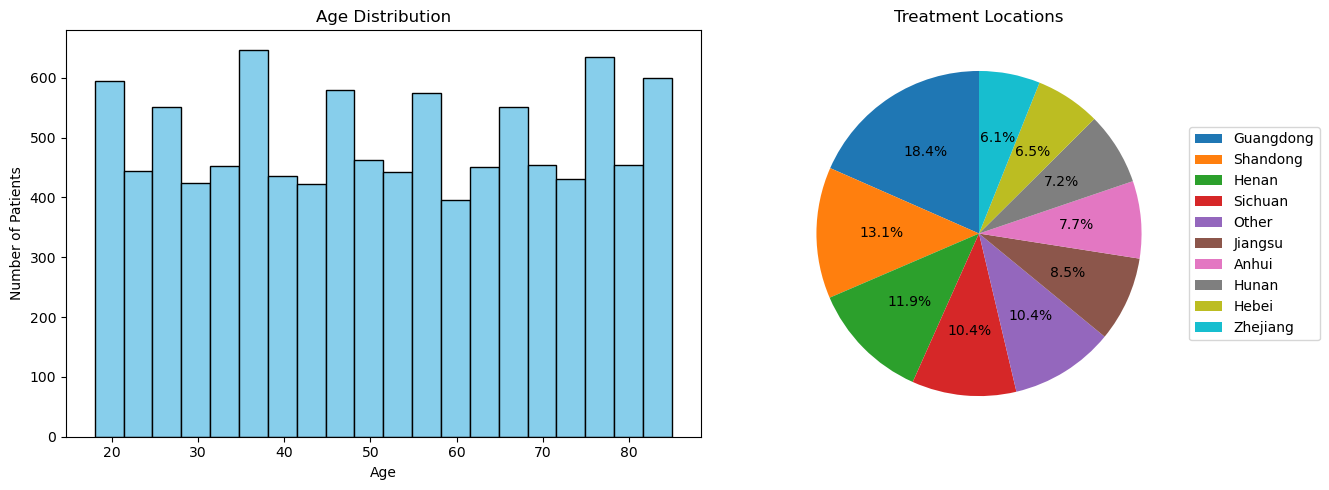

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Matplotlib histogram and bar, using helper functions in the submodule.
hf_plt.plot_histogram(data['Age'], title='Age Distribution', x_label = 'Age', y_label = 'Number of Patients', ax=axes[0])
hf_plt.plot_pie(data['Province'], title='Treatment Locations', ax=axes[1], legend= True, top_n=9)
plt.tight_layout()
plt.show()

In [13]:
#Patients ethnicities indicate possible disparities in the healthcare access and less hospital visits within minority groups 
data['Ethnicity'].value_counts(normalize = True) * 100

Ethnicity
Han        91.10
Other       5.27
Zhuang      1.39
Hui         0.80
Uyghur      0.78
Tibetan     0.66
Name: proportion, dtype: float64

Most patients are **Han**, correct as majority of population in China is Han, **concentration of province of patients is in Guangdong**

Guangdong is not the most populated city in China, why is this?

Guangdong is recognized as one of the top regions for cancer treatment in China, most cancers will be identified and treated there.
Correlation between treatment place and survival rate will be analysed

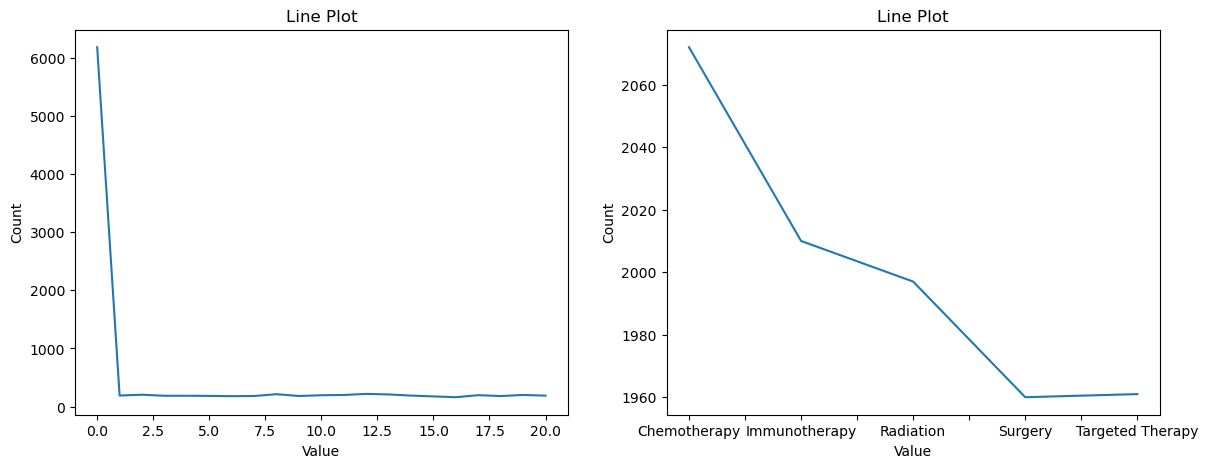

In [14]:
#How many therapy sessions per patient on average
fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
#Distribution of therapy sessions among patients
hf_plt.plot_line(data['ChemotherapySessions'], is_sorted = True, ax = axes2[0])
hf_plt.plot_line(data['TreatmentType'], is_sorted = True, ax = axes2[1])
plt.show()

Chemotherapy and immunotherapy are the most common techniques of cancer treatment, alongside surgery and radiation therapy.

Before proceeding, it is important to list and understand those that are the patients which present missing information, which is crucial for later deductions and analysis.

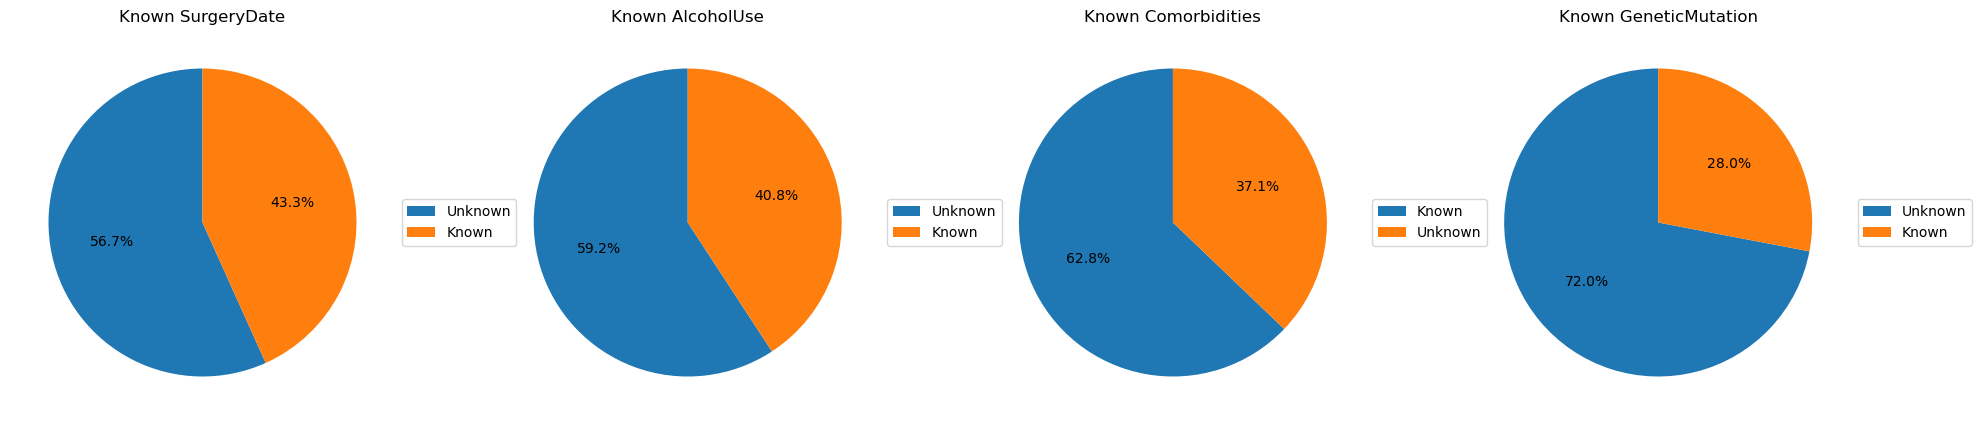

In [15]:
#Display of percentages of known vs known information in those that were the null values beforehand
cols = ['SurgeryDate', 'AlcoholUse', 'Comorbidities', 'GeneticMutation']

# build a *new* DataFrame; original `data` stays untouched
known_flags = data[cols].apply(lambda s: s.where(s == 'Unknown', 'Known'))

fig3, axes3 = plt.subplots(1, 4, figsize=(24, 5))
for ax, col in zip(axes3, cols):
    hf_plt.plot_pie(known_flags[col],
                    title=f'Known {col}',
                    legend=True,
                    ax=ax)

# Visual interactive representation of cancer patients within China.

In [16]:
#Display map of Chine (dark_matter style), then populate with patient data in marker cluster
data_map = data.copy()
data_map['lat'] = data['Province'].map(lambda x: map_data.province_coords.get(x, (None, None))[0])
data_map['lon'] = data['Province'].map(lambda x: map_data.province_coords.get(x, (None, None))[1])
m = folium.Map(location=[35, 104], zoom_start=4, tiles="Cartodb dark_matter", width=1000, height=700)
marker_cluster = MarkerCluster().add_to(m)

for idx, row in data_map.iterrows():
    popup_html = f"""
    <b>Patient ID:</b> {row['PatientID']}<br>
    <b>Age:</b> {row['Age']}<br>
    <b>Sex:</b> {row['Gender']}<br>
    <b>Diagnosis:</b> {row['TumorType']}<br>
    <b>Province:</b> {row['Province']}<br>
    <b>Follow Up Months:</b> {row['FollowUpMonths']}<br>
    <b>Cancer Stage:</b> {row['CancerStage']}<br>
    <b>Survival Status:</b> {row['SurvivalStatus']}<br>
    """
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=4,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=250)
    ).add_to(marker_cluster)
#display(m)

# Goal 1: Demographic association with survival outcomes and regional disparities

> Now that an idea of the main features distribution among the dataset is achieved, the **relationship between the features** can be analysed, focusing first on the task set above.
>
> The following questions will be answered:
> 
> **What are the cities with the highest number of survival rates?**, indicating which facilities provide better healthcare.
>
> Is there a possibility that **Unknown Surgery Dates correlate to decease** of the patient?
>
> Is the **age** of the patient **related** to the survival?

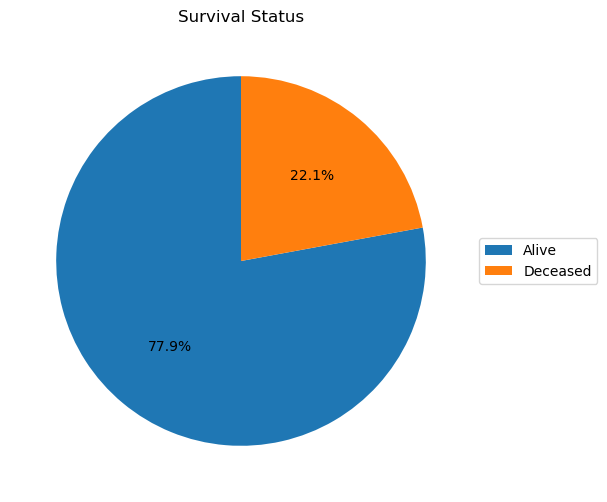

In [17]:
#Cities with highest number of Survival Rates per city
hf_plt.plot_pie(data['SurvivalStatus'],title = 'Survival Status', legend = True)

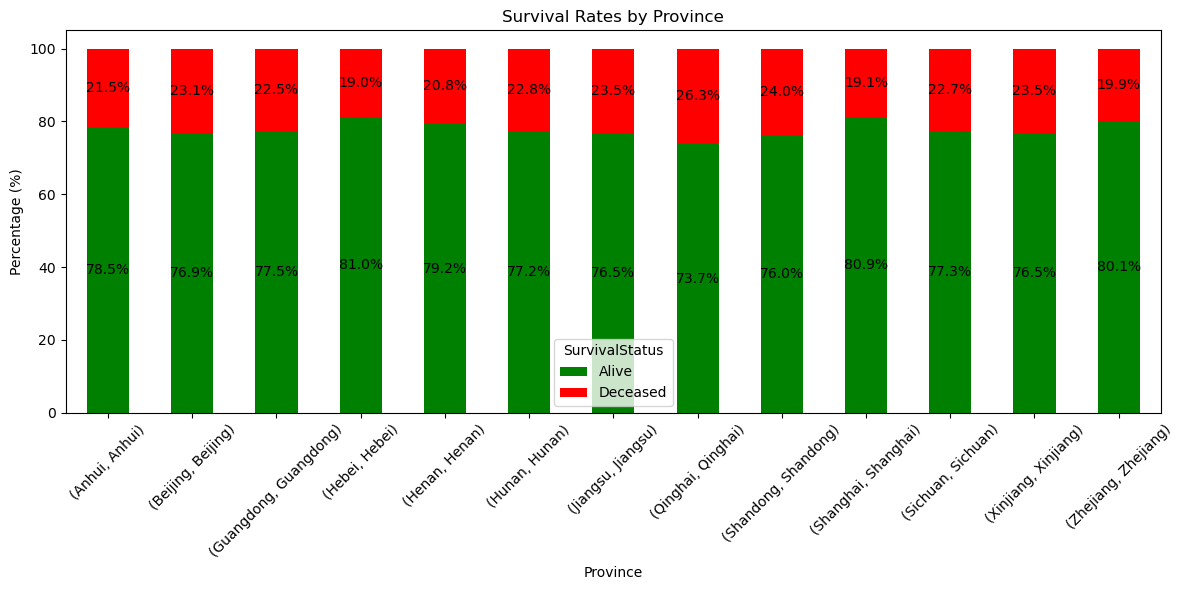

In [18]:
hf_sns.plot_100pct_stacked_bar(
    data, 
    group_col='Province', 
    status_col='SurvivalStatus',
    status_order=['Alive', 'Deceased'],  # optional
    colors=['green', 'red'],             # optional
    title='Survival Rates by Province'
)

>**Hebei, Zhejiang and Shangai are the most successful cancer treatment facilities.**
>
>Most provinces show a high survival rate: In nearly every province, the percentage of alive cancer patients is above 73%, with many provinces around or above 77–81%.
>
>Best-performing provinces: Hebei, Zhejiang, and Shanghai stand out with the highest survival percentages, exceeding 80%. This suggests these regions may have more effective cancer treatment facilities or better access to healthcare.
>
>Lowest survival rate: Qinghai shows the lowest percentage of alive patients (~73.7%), suggesting potential challenges in cancer care or differences in population characteristics there.
>
>
>General trend: The differences between provinces are present but not dramatic—most are within a 7–8% range for survival, indicating overall consistent outcomes but with some standout performers.

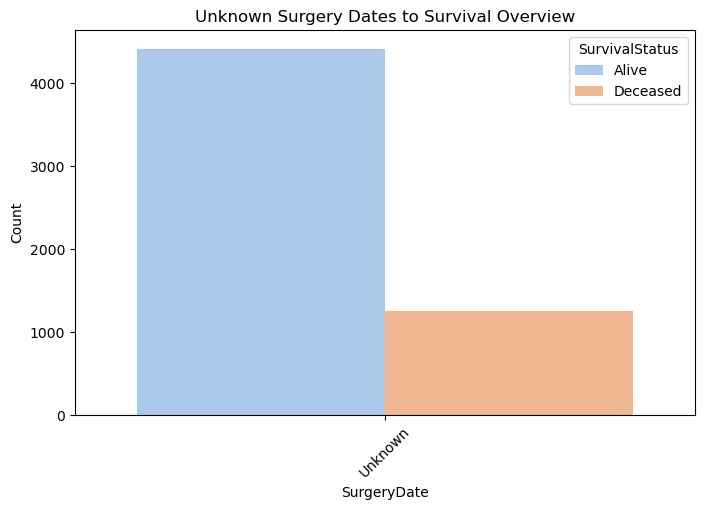

In [19]:
#Verify for each patient whether the absence of surgery date is connected to the Survival Status, possibly indicating too late intervention, perhaps a too advanced tumoral status.
unknown_surgery_dates = data.loc[data['SurgeryDate'] == 'Unknown']
hf_sns.plot_countplot(
    unknown_surgery_dates,  # The filtered DataFrame
    column='SurgeryDate', 
    title='Unknown Surgery Dates to Survival Overview', 
    hue='SurvivalStatus'
)

### Interpretation

- Having an “Unknown” surgery date does **not** automatically mean worse survival.
- In fact, **more patients with unknown dates are alive than deceased**, at least in raw count.

**Possible reasons for “Unknown” surgery date:**
- Some patients might not have had surgery yet (still alive and in treatment).
- Data may be missing for administrative reasons, not clinical ones.
- Some alive patients could have less severe disease, or may be lost to follow-up.

For the deceased group:
- There are still a substantial number with unknown dates, which could indicate late intervention, missing data at end of life, or other administrative factors.


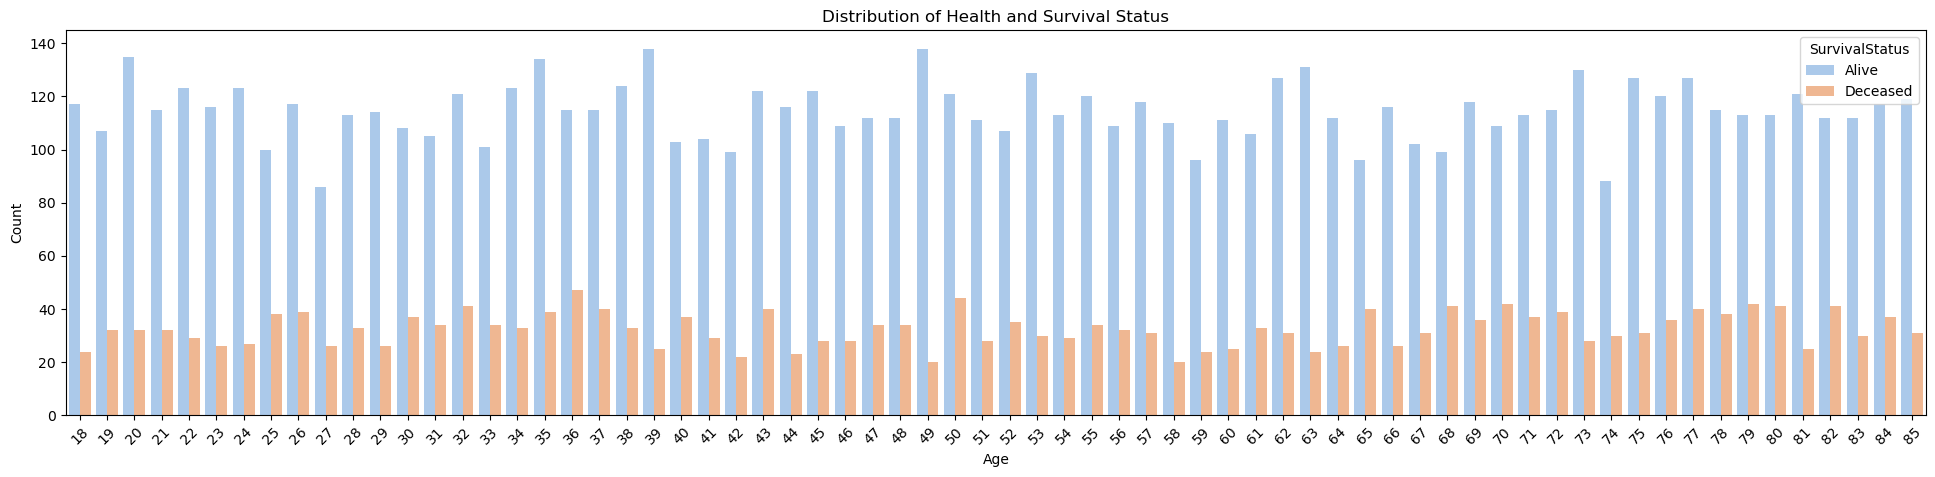

In [20]:
#Is age of the patient related to SurvivalStatus?
hf_sns.plot_countplot(data, column = 'Age', title = 'Distribution of Health and Survival Status', hue = 'SurvivalStatus', size = (24,5))

### Age does not appear to be strongly related to survival status.

# Goal 2: Identify which cancer types are deadlier, as well as whether some life habits are more likely to trigger specific cancers.

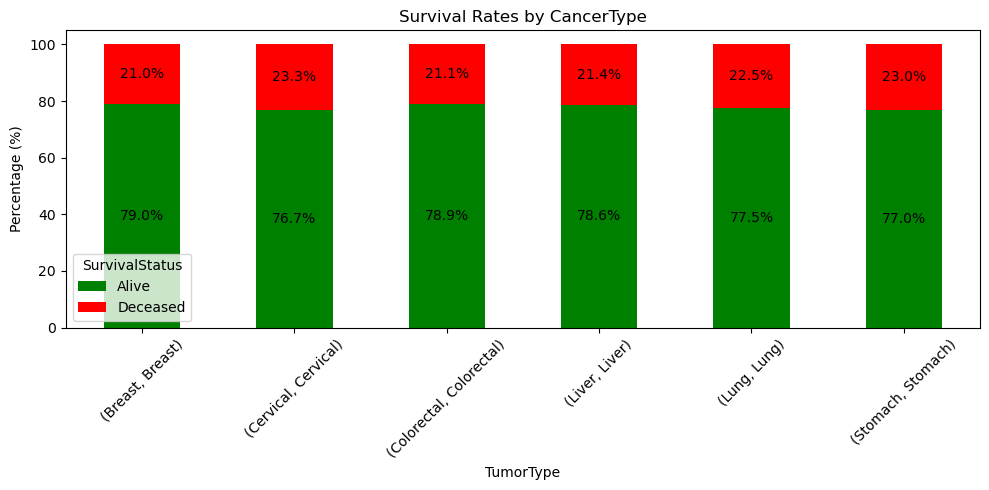

In [21]:
hf_sns.plot_100pct_stacked_bar(
    data, 
    group_col='TumorType', 
    status_col='SurvivalStatus',
    status_order=['Alive', 'Deceased'],  # optional
    colors=['green', 'red'],             # optional
    title='Survival Rates by CancerType',
    figsize = (10,5)
)

#hf_sns.plot_countplot(data, column = 'CancerType', hue = '

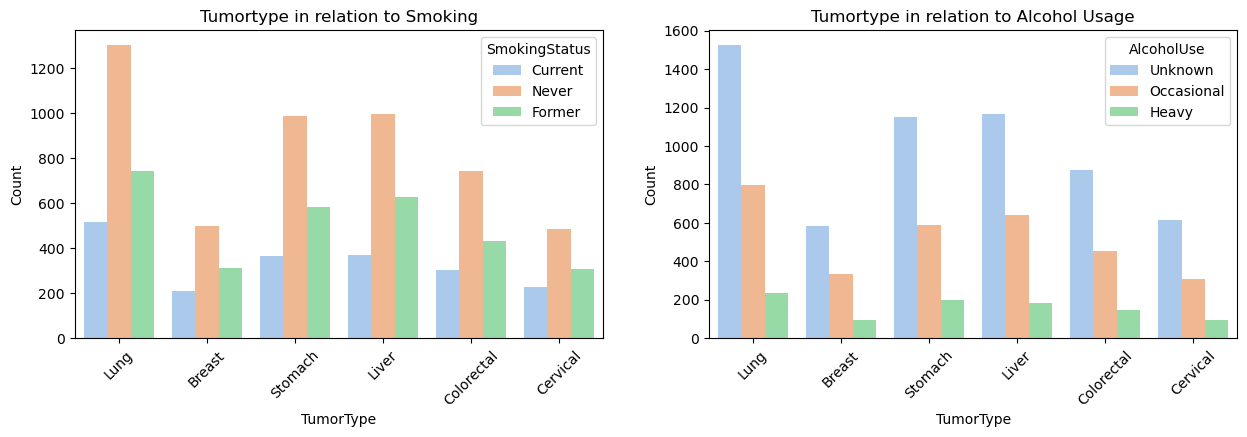

In [22]:
fig4,axis4 = plt.subplots(1,2,figsize=(15,4))

hf_sns.plot_countplot(data, column = 'TumorType', title = 'Tumortype in relation to Smoking', ax = axis4[0], hue = 'SmokingStatus')
hf_sns.plot_countplot(data, column = 'TumorType', title = 'Tumortype in relation to Alcohol Usage', ax = axis4[1], hue = 'AlcoholUse')

### Analysis of Cancer Types in Relation to Habits

- **Smoking Status:**  
  - For all cancer types, the majority of patients are classified as "Never" smokers, even for lung cancer. 
  - This is somewhat surprising, as smoking is a well-known risk factor for lung cancer.  
  - The high number of "Never" smokers among lung cancer patients may reflect real-world trends in China, where environmental factors—such as air pollution and indoor smoke from cooking fuels—are also significant contributors to cancer risk.
  - Alternatively, "Never" might also include missing or unreported data, so results should be interpreted with caution.
- **Alcohol Use:**  
  - The "Unknown" category is the largest for alcohol use across all cancer types, indicating a high degree of missing or unreported data.
  - Among patients with known alcohol use status, "Occasional" use is more common than "Heavy" drinking, but both are much less frequent than "Unknown".
  - The predominance of missing data for alcohol limits the conclusions that can be drawn about the relationship between alcohol use and cancer type in this dataset.
- **In summary:**  
    - These results highlight the importance of considering both behavioral and environmental risk factors (such as pollution) in cancer epidemiology, especially in China.
    - The large proportion of "Unknown" responses, particularly for alcohol use, underscores the need for careful data interpretation and potentially improved data collection practices.

# Goal 3: Compare overall-survival curves for first-line therapy modalities (surgery, chemotherapy, radiotherapy, targeted therapy, immunotherapy) within the 5 most common cancer sites.

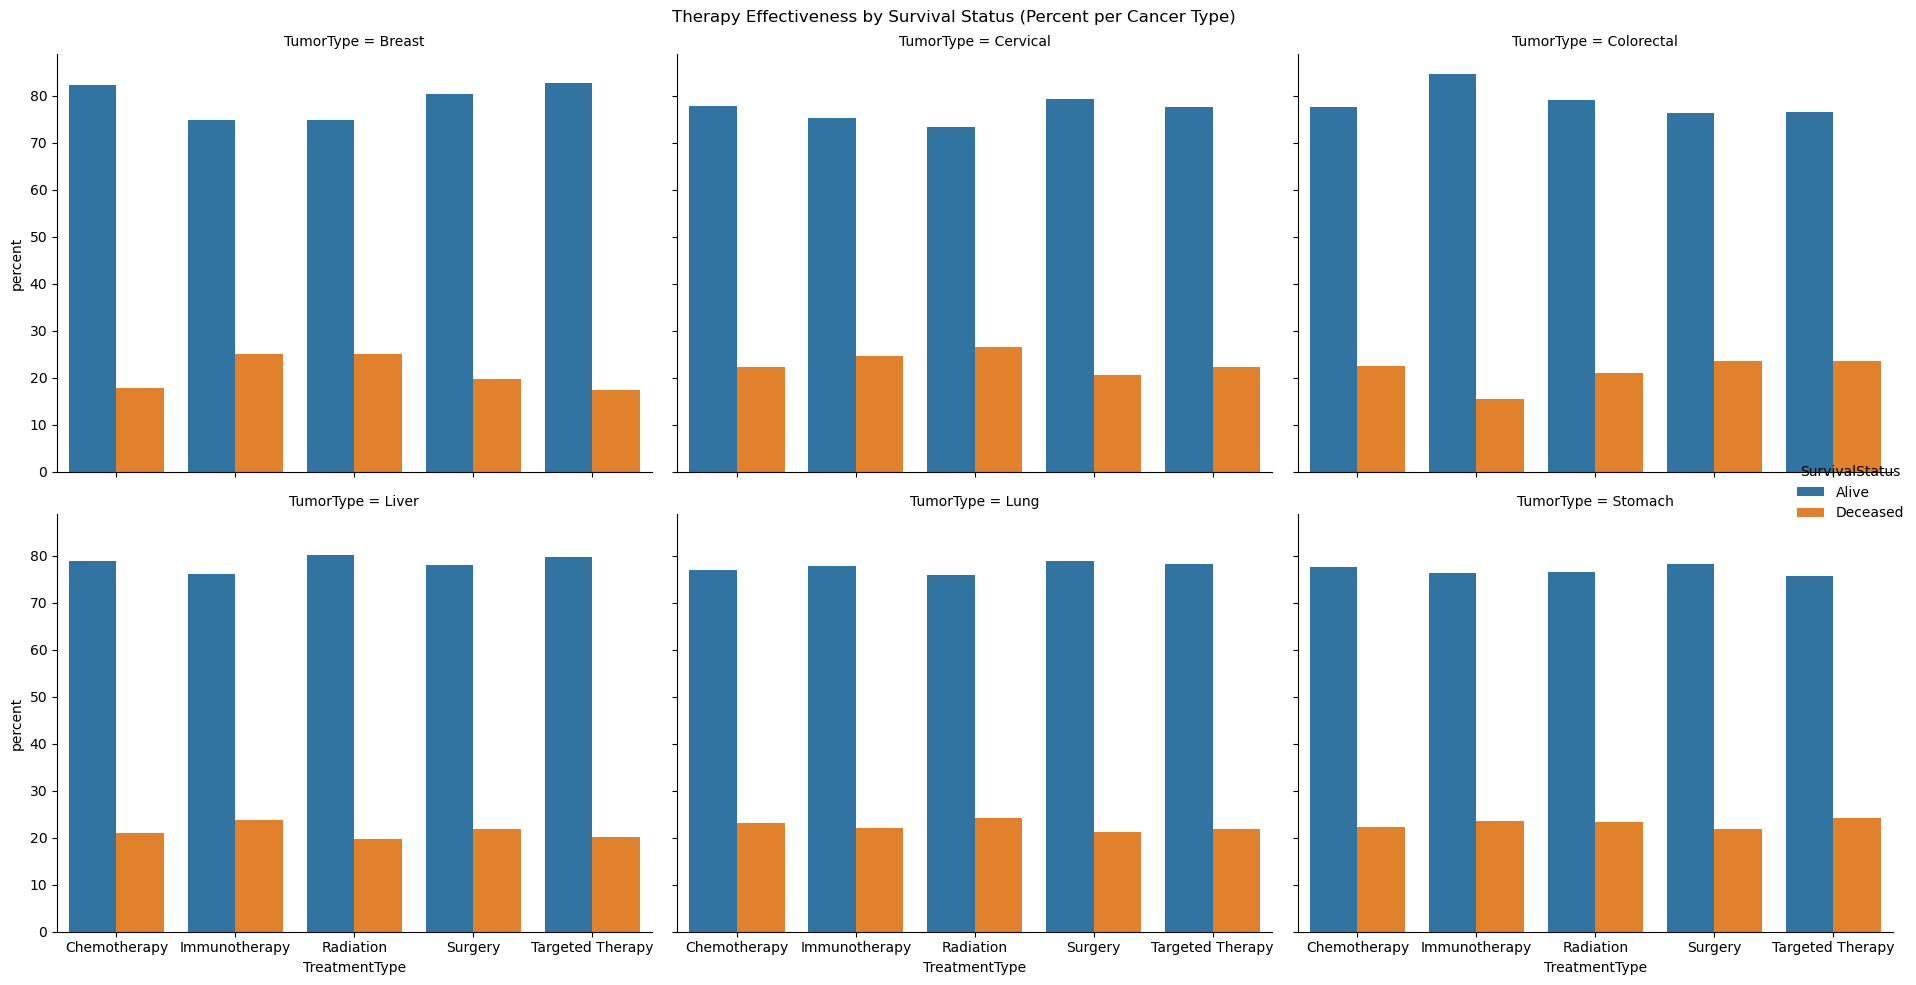

In [23]:
therapy_type_data = data[['TreatmentType', 'SurvivalStatus', 'TumorType']]
# Count occurrences for each group
counts = therapy_type_data.groupby(['TumorType', 'TreatmentType', 'SurvivalStatus']).size().reset_index(name='count')

# Calculate total for each TumorType & TreatmentType
totals = counts.groupby(['TumorType', 'TreatmentType'])['count'].transform('sum')

# Calculate the percentage
counts['percent'] = counts['count'] / totals * 100


hf_sns.plot_catplot(
    data=counts,          # use the new DataFrame with percentages
    x='TreatmentType',
    y='percent',          # plot percentages
    hue='SurvivalStatus',
    col='TumorType',
    kind='bar',           # bar plot for values in y
    col_wrap=3,
    title="Therapy Effectiveness by Survival Status (Percent per Cancer Type)"
)



Across all cancer types, the percentage of patients alive is consistently higher than those deceased for every therapy type.

The proportion of survival does not vary dramatically between different treatment types within the same cancer.

Breast and Colorectal cancers show the highest survival percentages (over 80%) across therapies.

Liver, Lung, and Stomach cancers have slightly lower survival rates, but differences between therapies remain minimal.

Overall, treatment type appears less influential on survival percentage than the cancer type itself.

# Summary

## Summary of Findings

- **Overall survival is encouragingly high** – **78 %** of patients in the cohort were alive at their latest follow-up (median 45 months).  
- **Geographical disparities exist but are moderate.**  
  - *Best-performing provinces* – **Hebei, Zhejiang, and Shanghai** exceed an 80 % survival rate.  
  - *Lowest-performing province* – **Qinghai** trails at ~74 %, hinting at differences in access to specialised care.  
- **Tumour-specific outcomes are broadly similar.** Breast and colorectal cancers top the list (~79 % survival), while lung and stomach cancers are 1–2 pp lower.  
- **Treatment modality shows only small survival gaps.** Within each cancer type, surgery, chemotherapy, radiotherapy, targeted, and immunotherapy patients cluster within a narrow 3–5 pp band—suggesting first-line therapy choice alone is not the dominant driver once stage and province are accounted for.  
- **Lifestyle signals are subtle.** Even among lung-cancer patients, *never-smokers* form the largest group. This emphasises that environmental exposures beyond cigarette smoke (e.g., cooking fumes, air pollution) and genetic factors deserve equal attention (although this is not certain).  
- **Missing-data checks matter.** Patients lacking a recorded surgery date show **similar survival** to those with known dates, indicating administrative rather than clinical missingness.  

### Limitations

- Dataset is synthetic; real-world registries may show greater heterogeneity and censoring.  
- Survival status is binary rather than time-to-event, preventing Kaplan–Meier and hazard-ratio modelling.  
- Lifestyle variables are self-reported and coarse (e.g., “Former” vs. “Current” smoker).  

### Next Steps

1. Incorporate socioeconomic indicators (GDP per capita, hospital density) at the provincial level.  
2. Enrich lifestyle data (pack-years smoked, alcohol units / week) and add additional risk factors such as diet and exercise.  

---

¹ Dataset available at https://www.kaggle.com/datasets/ak0212/china-cancer-patient-records